# Tutorial III: Transfer Learning

<p>
AICP, 2024<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected neural network to perform handwritten digit recognition using pytorch

## 1. Load necessary libraries



In [1]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio import datasets, transforms
from torchvision import transforms as vtransforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader

import librosa
from IPython.display import Audio as AudioDisplay
from IPython.display import display

## 2. Audio dataset

In [2]:
# See dataset details, https://huggingface.co/datasets/Codec-SUPERB/gtzan_music_speech_synth
from datasets import load_dataset

# Load the marsyas/gtzan dataset
dataset = load_dataset("Codec-SUPERB/gtzan_music_speech_synth", trust_remote_code=True, split="original")

# Print the dataset info
print(dataset)

Dataset({
    features: ['audio', 'id'],
    num_rows: 128
})


In [3]:
dataset['id']

['tfds_id_gtzan-music-speech-train-tfrecord-00000-of-00004-10',
 'tfds_id_gtzan-music-speech-train-tfrecord-00000-of-00004-31',
 'tfds_id_gtzan-music-speech-train-tfrecord-00001-of-00004-14',
 'tfds_id_gtzan-music-speech-train-tfrecord-00001-of-00004-2',
 'tfds_id_gtzan-music-speech-train-tfrecord-00001-of-00004-24',
 'tfds_id_gtzan-music-speech-train-tfrecord-00002-of-00004-23',
 'tfds_id_gtzan-music-speech-train-tfrecord-00002-of-00004-26',
 'tfds_id_gtzan-music-speech-train-tfrecord-00003-of-00004-0',
 'tfds_id_gtzan-music-speech-train-tfrecord-00003-of-00004-13',
 'tfds_id_gtzan-music-speech-train-tfrecord-00003-of-00004-14',
 'tfds_id_gtzan-music-speech-train-tfrecord-00003-of-00004-2',
 'tfds_id_gtzan-music-speech-train-tfrecord-00003-of-00004-26',
 'tfds_id_gtzan-music-speech-train-tfrecord-00003-of-00004-27',
 'tfds_id_gtzan-music-speech-train-tfrecord-00000-of-00004-0',
 'tfds_id_gtzan-music-speech-train-tfrecord-00000-of-00004-16',
 'tfds_id_gtzan-music-speech-train-tfrecord-

In [9]:
dataset[0]

{'audio': {'path': None,
  'array': array([-0.20541382, -0.29391479, -0.29464722, ...,  0.12857056,
          0.14532471,  0.07556152]),
  'sampling_rate': 48000},
 'id': 'tfds_id_gtzan-music-speech-train-tfrecord-00000-of-00004-10'}

In [10]:
dataset['audio'][0]['array'].dtype

dtype('float64')

In [11]:
dataset['audio'][0]['array'].shape[0]/48000

30.0

In [12]:
# check all sampling_rate are 48k

for smpl in dataset['audio']:
    sr = smpl['sampling_rate']
    assert sr == 48000, f'sr={sr}'

# check all samples are 48k*30s long

for smpl in dataset['audio']:
    l = len(smpl['array'])
    assert l == 30*48000, f'len(smaple)={l}'

In [8]:
idx = 127
AudioDisplay(dataset['audio'][idx]['array'], rate=48000)  

In [13]:
norm_std = np.concatenate([v['array'] for v in dataset['audio']]).std()
print(norm_std)

0.08237769898653845


## 3. Dataset preprocessing

In [14]:
orig_sr = 48_000
tgt_sr = 16_000

crop_sec = 8
crop_len = int(crop_sec * orig_sr)  # 0.2 sec crops
orig_len = 30 * orig_sr  # 0.2 sec crops
max_ofs = orig_len - crop_len

def transform(x):
    audio_samples = [v['array'] for v in x['audio']]
    n_samples = len(audio_samples)

    offsets = np.random.randint(0, max_ofs, size=n_samples)
    crops = [sample[offset:offset + crop_len] for sample, offset in zip(audio_samples, offsets)]
    crops_f32 = [c.astype(np.float32)/norm_std for c in crops]
    crops_tensors_f32 = [torch.tensor(c) for c in crops_f32]

    resamplerer = transforms.Resample(orig_freq=orig_sr, new_freq=tgt_sr)
    resampled_crops = [resamplerer(c) for c in crops_tensors_f32]

    return {'audio' : resampled_crops}

dataset.set_transform(columns='audio', transform=transform)

In [15]:
for v in dataset:
    print(v)
    break

{'audio': tensor([0.0470, 0.0704, 0.0155,  ..., 3.4971, 2.2211, 1.0651])}


In [16]:
sample_idx = 5
sample = dataset['audio'][sample_idx].numpy()
AudioDisplay(sample, rate=tgt_sr)

In [17]:
label_list = ['music', 'speech']

## 4. Base Model

In [18]:
from transformers import Wav2Vec2Model, Wav2Vec2BertProcessor, AutoConfig

model_name_or_path = 'facebook/wav2vec2-base'
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=len(label_list),
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)

d:\development\Anaconda3\envs\aicp\lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [19]:
model = Wav2Vec2Model(config=config)

In [20]:
model

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [24]:
sample = dataset[5]['audio']
AudioDisplay(sample, rate=tgt_sr)

In [25]:
res = model(sample.reshape(1, -1))

In [26]:
res.keys()

odict_keys(['last_hidden_state', 'extract_features'])

In [27]:
res['last_hidden_state'].shape, res['extract_features'].shape

(torch.Size([1, 399, 768]), torch.Size([1, 399, 512]))

In [28]:
features = res['extract_features'].detach().numpy()[0]

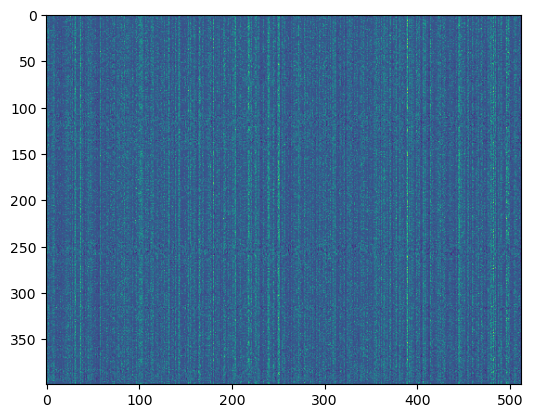

In [29]:
plt.imshow(features)

In [30]:
s = sample.numpy()
t = [s*0.1, s, s*10, s*100, s*1000]
t = torch.tensor(t)
features = model(t)['extract_features'].detach().numpy()
print(features.shape)

C:\Users\newor\AppData\Local\Temp\ipykernel_52004\1222197148.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  t = torch.tensor(t)


(5, 399, 512)


In [34]:
# for each sample calcilate the mean across time - mean avaragge pooling, 
# and save per sample

mean_features = []
std_features = []
full_features = []
dataset_crops = []
for sample in dataset['audio']:

    dataset_crops.append(sample.detach().numpy())
    
    res = model(sample.reshape(1, -1))
    features = res['extract_features'].detach().numpy()[0]

    # full_features.append(features)
    mean_features.append(features.mean(axis=0))
    std_features.append(features.std(axis=0))

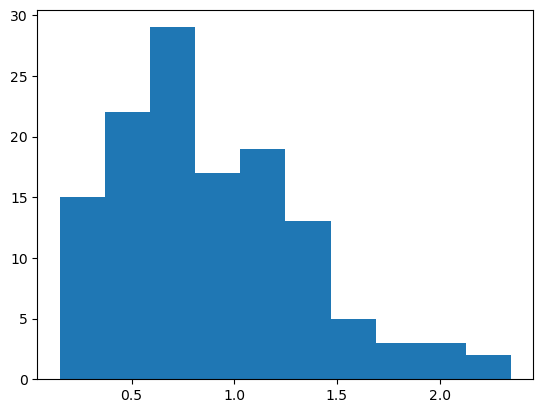

In [35]:
plt.hist([v.std() for v in dataset_crops]);

In [36]:
c = dataset_crops[0]
c.mean(), c.std()

(0.021644732, 1.326826)

C:\Users\newor\AppData\Local\Temp\ipykernel_13980\2990303353.py:8: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



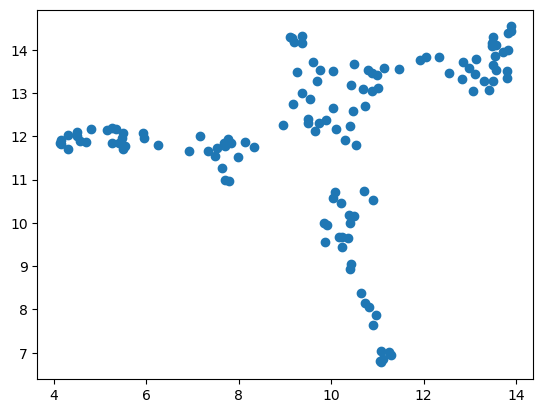

In [115]:
import umap

# Create a UMAP object
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean')

embedding = umap_model.fit_transform(std_features)

plt.scatter(embedding[:, 0], embedding[:, 1], cmap='viridis')  # , c=labels

In [116]:
import plotly.graph_objects as go
from ipywidgets import Output, VBox

In [117]:
# play audio once with python
import soundcard as sc

speaker = sc.default_speaker()

In [118]:
def get_selection_indices(x, y, selection_list, audio_samples, play_sec=1., s=None, c=None):
    f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')], layout=go.Layout(width=600, height=600))
    n = len(x)
    scatter = f.data[0]
    colors_0 = c or ['#a3a7e4'] * n
    scatter.marker.color = colors_0
    sizes_0 = s or [10] * n
    scatter.marker.size = sizes_0

    f.layout.hovermode = 'closest'

    #create our callback function
    out = Output()
    @out.capture(clear_output=True)
    def select_points(trace, points, selector):
        c = list(colors_0).copy()
        s = list(sizes_0).copy()

        for i in points.point_inds:
            s[i] = 20

        selection_list.clear()
        selection_list.extend(list(points.point_inds))

        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s

    @out.capture(clear_output=True)
    def click_point(trace, points, selector):
        # print(points.point_inds, selector)
        sample = audio_samples[points.point_inds[0]]
        sample_crop = sample[0:int(play_sec * tgt_sr)]
        speaker.play(sample_crop, samplerate=tgt_sr)

    scatter.on_selection(select_points)
    scatter.on_click(click_point)
    return VBox([f, out])

In [119]:
selection_list = []
get_selection_indices(x=embedding[:, 0], y=embedding[:, 1], selection_list=selection_list, audio_samples=dataset_crops)

    'data': [{'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
…

In [120]:
for sample_idx in selection_list:
    print(sample_idx)
    display(AudioDisplay(dataset_crops[sample_idx], rate=tgt_sr))

In [ ]:
# perform PCA on the all features
all_features = np.concatenate(full_features, axis=0)

from sklearn.decomposition import PCA

# do PCA and the plot the explained variance ratio
pca = PCA(n_components=512)
pca.fit(all_features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [121]:
import pandas as pd
# load `sample_annotatetions.csv` with class information as integer label 0, 1

# labels = pd.read_csv('sample_annotatetions.csv').to_numpy()

labels = np.random.randint(0, 2, size=(128))
print(labels.shape, labels.dtype)

# add labels to the dataset
dataset_l = dataset.add_column("labels", labels)

def transform_with_labels(x):
    # apply the same transformation as before
    d = transform(x)
    
    # add labels as tensors

    #d["audio"] = [x.view(1, -1) for x in d["audio"]]
    d["labels"] = torch.tensor(x["labels"])

    return d

# apply the transformation
dataset_l.set_transform(transform_with_labels)



(128,) int32


In [122]:
dataset_l[0]

{'audio': tensor([-0.0494,  1.9375,  3.5019,  ...,  0.0610,  0.0438,  0.0487]),
 'labels': tensor(1)}

In [123]:
dataset_splits = dataset_l.train_test_split(test_size=0.2)

print(len(dataset_splits['train']), len(dataset_splits['test']))


dataset_train, dataset_test = dataset_splits['train'], dataset_splits['test']

102 26


In [124]:
# create data loaders\

batch_size = 20
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

for v in train_loader:
    print(v['audio'].shape), print(v['labels'].shape)
    break

torch.Size([20, 128000])
torch.Size([20])


 Let's take a look at some of the example images

In [131]:
class Transfer_leaarning_W2V(nn.Module):
    def __init__(self, model, n_input, n_hiddens, n_output):
        super(Transfer_leaarning_W2V, self).__init__()
        self.feature_extractor = model

        # freeze the feature extractor
        for p in self.feature_extractor.parameters():
            p.requires_grad = False

        self.pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc1 = nn.Linear(in_features=n_input, out_features=n_hiddens, dtype=torch.float)
        self.fc2 = nn.Linear(in_features=n_hiddens, out_features=n_output, dtype=torch.float)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x['extract_features']
        x = x.transpose(1, 2)
        # print(x.shape)
        # x = self.pool(x)
        # print(x.shape)
        # x = x[:, :, 0]
        # print(x.shape)
        x = torch.std(x, dim=-1)
        # print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float)
        
        x = self.forward(x)

        c = torch.argmax(x, dim=1)
        return c.detach().numpy()

    def predict_proba(self, x):
        x = self.forward(x)
        probs = F.softmax(x, dim=1)[:, 1]

        return probs.detach().numpy()
    

model_tl = Transfer_leaarning_W2V(model=model, n_input=512, n_hiddens=32, n_output=2)


In [132]:
v['audio'].shape

torch.Size([20, 128000])

In [133]:
model_tl(v['audio'][:2])

tensor([[0.2868, 0.3431],
        [0.2989, 0.3538]], grad_fn=<AddmmBackward0>)

In [134]:
def get_npars(model):
    """
    Returns the total number of parameters in the given PyTorch model.
    For each parmaeter in the model, the function multiplies the elements of the shape
    of the parameter tensor to get the total number of parameters.
    
    Args:
        model (torch.nn.Module): The PyTorch model to get the number of parameters for.
    
    Returns:
        tuple(int, int): The total number of parameters in the model and the number of trainable parameters.
    """
    n_all = np.sum([np.prod(list(p.shape)) for p in model.parameters()])
    n_tra = np.sum([np.prod(list(p.shape)) for p in model.parameters() if p.requires_grad])
    return int(n_all), int(n_tra)

In [135]:
get_npars(model_tl)  # (315_455_202, 16_482)

(94388194, 16482)

In [136]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(model_tl.parameters(), lr=0.001)


Defining a training function:

In [137]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for sample in trainloader:
        print('.', end='')
        audio = sample['audio']
        #print(audio.shape)
        labels = sample['labels']
        optimizer.zero_grad()  # reset gradients
        output = model(audio)
        loss = criterion(output, labels)
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        running_loss += loss.item()
    print()
    return running_loss / len(trainloader)

Defining a testing function:

In [138]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct = 0
    with torch.no_grad():
        for sample in testloader:
            audio = sample['audio']
            labels = sample['labels']
            output = model(audio)
            loss = criterion(output, labels)
            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            correct = torch.sum(pred == labels)
            n_correct =+ correct
    return running_loss / len(testloader), n_correct/len(testloader)/testloader.batch_size

In [139]:
test_loader.batch_size

20

Training the model

In [140]:
num_epochs = 5
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model_tl, train_loader, criterion, optimizer)
    test_loss, test_acc = test(model_tl, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, TestAcc: {test_acc:.4f}')

.

d:\development\Anaconda3\envs\aicp\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning:

`torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.



....
Epoch 1/5, Train Loss: 0.7196, Test Loss: 0.7060, TestAcc: 0.5500
.....
Epoch 2/5, Train Loss: 0.6884, Test Loss: 0.6980, TestAcc: 0.4500
.....
Epoch 3/5, Train Loss: 0.7398, Test Loss: 0.6990, TestAcc: 0.4500
.....
Epoch 4/5, Train Loss: 0.7094, Test Loss: 0.7037, TestAcc: 0.5500
.....
Epoch 5/5, Train Loss: 0.7124, Test Loss: 0.6895, TestAcc: 0.5500


Visualize the loss curves

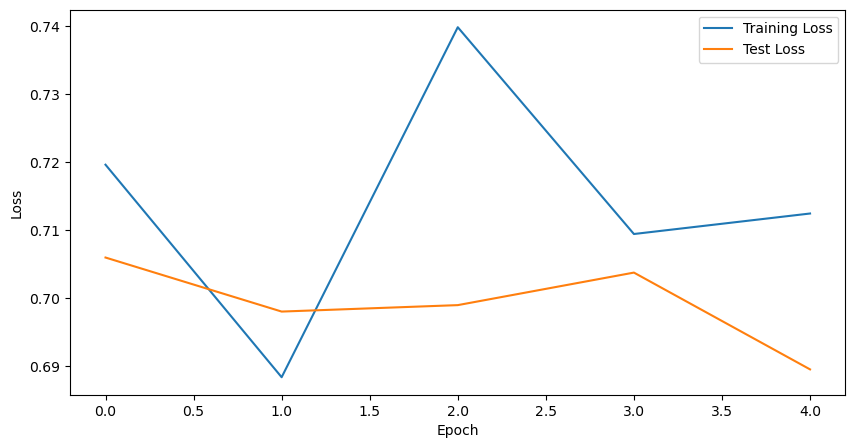

In [141]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

In [142]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    #images_list = []
    with torch.no_grad():
        for sample in loader:
            audio = sample['audio']
            label = sample['labels']
            output = model(audio)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            # images_list.extend(audio)
    return predictions, labels# , images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

# Get predictions, labels, and images
predictions, labels = get_predictions(model_tl, test_loader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.6
